In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [6]:
torch.manual_seed(1)

In [4]:
import os
import sys
import tqdm

In [5]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [225]:
import glob
import pickle

In [226]:
glob.glob('../data/simulated/*')

['../data/simulated/hawkes_synth_data_1d.pkl',
 '../data/simulated/hawkes_synth_data_2d.pkl',
 '../data/simulated/README.md']

In [227]:
def process_loaded_sequences(loaded_hawkes_data: dict):
    # Tensor of sequence lengths
    seq_lengths = torch.Tensor(loaded_hawkes_data['lengths']).int()
    # Reorder by decreasing order for PyTorch to understand
    seq_lengths, reorder_indices_ = seq_lengths.sort(descending=True)

    event_times_list = loaded_hawkes_data['timestamps']
    event_types_list = loaded_hawkes_data['types']
    event_times_list = [torch.from_numpy(e) for e in event_times_list]
    event_types_list = [torch.from_numpy(e) for e in event_types_list]

    # Build a data tensor by padding
    times_tensor = nn.utils.rnn.pad_sequence(event_times_list).float()
    times_tensor = torch.cat((torch.zeros_like(times_tensor[:1,:]), times_tensor))
    # Reorder by descending sequence length
    times_tensor = times_tensor[:, reorder_indices_]
    
    # Build a types data tensor by padding
    types_tensor = nn.utils.rnn.pad_sequence(event_types_list)
    process_dim = types_tensor.max()
    # K is the Beginning-of-sequence event now; shift all other event types
    types_tensor = torch.cat(
        ((process_dim+1)*torch.ones_like(types_tensor[:1,:]), types_tensor))
    # Reorder by descending sequence length
    types_tensor = types_tensor[:, reorder_indices_]
    return times_tensor, types_tensor, seq_lengths

## 1D process

In [10]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_1d.pkl", "rb") as f:
    loaded_hawkes_data = pickle.load(f)

In [11]:
loaded_hawkes_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [12]:
mu = loaded_hawkes_data['mu']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print(mu)
print(decay)
print(tmax)

1.0
5.0
60.0


In [13]:
times_tensor, types_tensor, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

## 2D process

In [228]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_2d.pkl", "rb") as f:
    loaded_hawkes_2d_data = pickle.load(f)

In [229]:
loaded_hawkes_2d_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [230]:
print(loaded_hawkes_2d_data['mu'])
print(loaded_hawkes_2d_data['alpha'])
print(loaded_hawkes_2d_data['decay'])
tmax = loaded_hawkes_2d_data['tmax']
print(f"tmax: {tmax}")

[0.7 1. ]
[[0.1  0.15]
 [0.01 0.01]]
0.01
tmax: 60.0


In [231]:
times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_2d_data)

In [233]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]

In [234]:
onehot_types = one_hot_embedding(seq_types, 3)

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = \phi\left(W_{\lambda} h(t)\right)
$$

with $\phi$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [310]:
from models.decayrnn import HawkesDecayRNN
from train_functions import train_decayrnn

In [311]:
hidden_size = 12
model = HawkesDecayRNN(2, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

In [312]:
# define training loop
train_size = int(0.4*times_tensor.size(1))
EPOCHS = 30
BATCH_SIZE = 32
print("Train size %d" % train_size)

Train size 800


In [313]:
loss_hist = []
for e in range(1, EPOCHS+1):
    # Epoch loop
    epoch_loss = []
    tr_loop_range = tqdm.tqdm_notebook(range(0, train_size, BATCH_SIZE),
                                       file=sys.stdout, desc="Epoch %d" % e)
    for i in tr_loop_range:
        sequence = times_tensor[:, i:(i+BATCH_SIZE)]
        sub_seq_types = onehot_types[:, i:(i+BATCH_SIZE)]
        sub_seq_lengths = seq_lengths[i:(i+BATCH_SIZE)]
        train_info, loss = train_decayrnn(model, optimizer, sequence,
                                          sub_seq_types, sub_seq_lengths,
                                          tmax)
        epoch_loss.append(loss)
    epoch_loss = np.mean(epoch_loss)
    loss_hist.append(epoch_loss)  # append the final loss of each epoch

In [314]:
loss_hist

[157.9989566040039,
 79.98040985107421,
 55.33236236572266,
 42.25499786376953,
 31.53848243713379,
 20.97218589782715,
 13.126650915145873,
 6.404001216888428,
 1.4379749727249145,
 -4.016049345731735,
 -8.997094383239746,
 -13.029756774902344,
 -17.953308982849123,
 -21.483899116516113,
 -25.071026000976563,
 -28.916421203613282,
 -31.7189168548584,
 -35.17062995910644,
 -38.79066558837891,
 -40.99279937744141,
 -44.19649597167969,
 -46.63009231567383,
 -48.815986480712894,
 -51.335526123046876,
 -54.13136260986328,
 -55.62823226928711,
 -58.56824966430664,
 -61.215284271240236,
 -62.62173553466797,
 -64.88015060424804]

Text(0, 0.5, 'Loss')

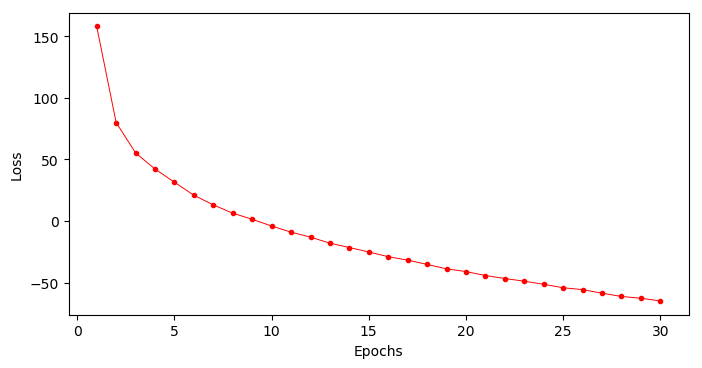

In [315]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
epochs_range = list(range(1, EPOCHS+1))
ax.plot(epochs_range, loss_hist, color='red',
         linewidth=.7, marker='.')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

the following tensor has shape 2 * 2 * 3, and on the third dim, we have three values and only one is right (1 instead of zero)

In [275]:
x = torch.Tensor([
    [
        [0, 2, -1],
        [2, 0, 0]
    ],
    [
        [5, 0, 0],
        [0, 3, 0]
    ]
])

In [253]:
x.shape

torch.Size([2, 2, 3])

In [276]:
indices = torch.LongTensor([
    [
        [0, 1, 0],
        [1, 0, 0]
    ],
    [
        [1, 0, 0],
        [0, 1, 0]
    ]
])

In [277]:
x*indices.float()

tensor([[[ 0.,  2., -0.],
         [ 2.,  0.,  0.]],

        [[ 5.,  0.,  0.],
         [ 0.,  3.,  0.]]])

In [266]:
torch.index_select(x, 2, indices)

RuntimeError: invalid argument 3: Index is supposed to be an empty tensor or a vector at /opt/conda/conda-bld/pytorch_1533739672741/work/aten/src/TH/generic/THTensorMath.cpp:318

In [56]:
gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)

ValueError: only one element tensors can be converted to Python scalars

In [169]:
# Build a statistic for the no. of events
gen_seq_lengths = []
n_gen_seq = 1000 # number of generated sequences
for i in range(n_gen_seq):
    gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)

In [170]:
MODEL_NAME = "Decay-RNN"

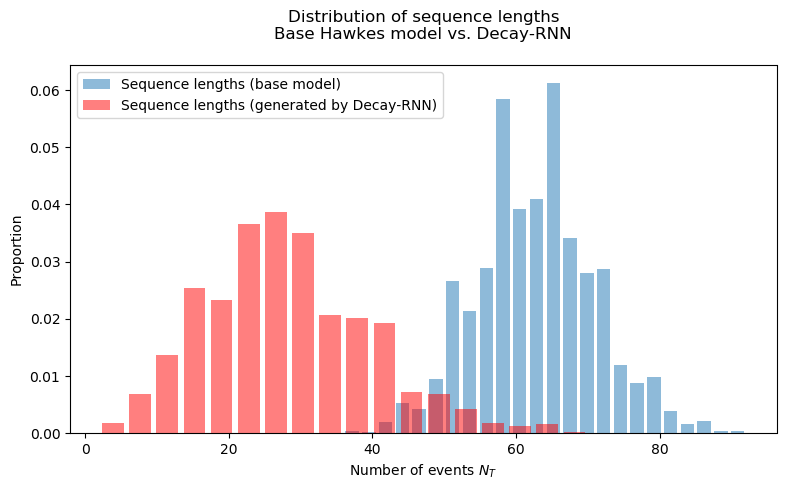

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
_ = ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
_ = ax.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            rwidth=0.8, alpha=0.5, color='red', density=True)
ax.legend()
ax.set_ylabel('Proportion')
ax.set_xlabel('Number of events $N_T$')
ax.set_title("""Distribution of sequence lengths
Base Hawkes model vs. {:}
""".format(MODEL_NAME))
fig.tight_layout()

In [172]:
RESULT_BASEDIR = "../results"
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}.{:}.pdf".format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME))

The number of events does not fit.

In [173]:
def plot_events_and_intensity(event_times, hidden_states, event_decay):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True,
                                   dpi=120,
                                   gridspec_kw = {'height_ratios':[3, 0.3]},
                                   figsize=(10,6))
    time_arr = np.linspace(0, tmax, 1000)
    n_events = event_times.shape[0] - 1
    max_intens = max(e.max() for e in hidden_states)
    min_intens = min(e.min() for e in hidden_states)
    y_intens = []
    curr_index = 0
    for ti in time_arr:
        if curr_index < len(hidden_states)-1 and ti > event_times[curr_index+1]:
            curr_index += 1
        hi = hidden_states[curr_index]
        li = model.intensity_activ(model.intensity_layer(hi)).detach().numpy()
        dec = event_decay[curr_index].numpy()
        t_incr = ti - event_times[curr_index]  # >= 0 by construction
        y_intens.append(li*np.exp(-dec*t_incr))
    event_intens = [model.intensity_activ(model.intensity_layer(h)).item()
                    for h in hidden_states]
    ax0.scatter(event_times[1:], event_intens,
                facecolor='k',
                s=6, alpha=0.7)
    ax0.set_ylabel("Event intensities $\lambda_t$")
    ax0.plot(time_arr, y_intens, color='r',
             linewidth=.7, linestyle='--')
    ax1.scatter(event_times[1:], np.random.rand(n_events),
                alpha=0.4, s=16)
    ax1.set_ylim((-0.3,1.3))
    ax1.set_xlabel("Time $t$")

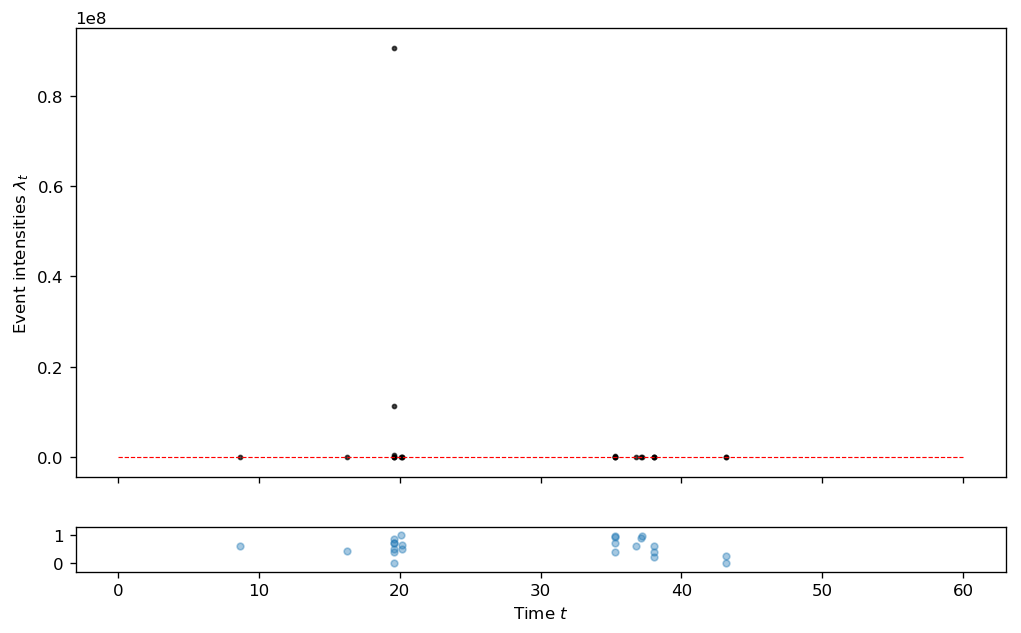

In [174]:
gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)
plot_events_and_intensity(gen_event_times, gen_event_intens, gen_event_decay)